# Предварительный анализ данных выпускного проекта (телекоммуникации)

## Описание проекта

Оператор связи хочет научиться предсказывать отток клиентов, для того чтобы предлагать им промокоды и специальные условия в этом случае. Компания предлагает следующие услуги:
1. Телефонная связь (с возможностью подключения нескольких линий одновременно)
2. Интернет (DSL и Fiber Optic)
3. Доп. услуги:
- DeviceProtection
- OnlineSecurity
- TechSupport
- OnlineBackup
- StreamingTV
- StreamingMovies

## Описание данных

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Информация о договорах актуальна на 1 февраля 2020.

## Цель проекта

Построить модель, способную наиболее точно предсказать собирается ли уходить клиент, используя данные об используемых им услугах, их стоимости, а также его персональных данных. Минимальная точность предсказаний по метрике AUC-ROC >= 0.85.

## Поиск пропусков и повторений

In [3]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import date
import phik
from phik.report import plot_correlation_matrix
import seaborn as sns

from scipy.stats import uniform as sp_randFloat
from scipy.stats import randint as sp_randInt
import random

from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score
)
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score,
    roc_curve
)
from catboost import CatBoostClassifier

In [4]:
state = 280823

In [5]:
#ссылки на датасеты не включаю по правилам Яндекс.Практикума
contract = pd.read_csv()
personal = pd.read_csv()
internet = pd.read_csv()
phone = pd.read_csv()

In [6]:
contract.info()
contract.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5
5,9305-CDSKC,2019-03-01,No,Month-to-month,Yes,Electronic check,99.65,1150.96
6,1452-KIOVK,2018-04-01,No,Month-to-month,Yes,Credit card (automatic),89.10,2058.21
7,6713-OKOMC,2019-04-01,No,Month-to-month,No,Mailed check,29.75,300.48
8,7892-POOKP,2017-07-01,No,Month-to-month,Yes,Electronic check,104.80,3573.68
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.15,1628.35


In [7]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [8]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [9]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [10]:
print(contract.duplicated().value_counts())
print(personal.duplicated().value_counts())
print(internet.duplicated().value_counts())
print(phone.duplicated().value_counts())

False    7043
dtype: int64
False    7043
dtype: int64
False    5517
dtype: int64
False    6361
dtype: int64


In [11]:
print(contract['customerID'].duplicated().value_counts())
print(personal['customerID'].duplicated().value_counts())
print(internet['customerID'].duplicated().value_counts())
print(phone['customerID'].duplicated().value_counts())

False    7043
Name: customerID, dtype: int64
False    7043
Name: customerID, dtype: int64
False    5517
Name: customerID, dtype: int64
False    6361
Name: customerID, dtype: int64


Пропусков нет, дубликатов (полных и неполных в столбце customerID) тоже нет. Значит, у одного клиента может быть только один договор (все равно остается шанс, что ему присваевается новый ID при перезаключении договора). Перейдем к более подробному разбору датасетов.

## Анализ  данных

У датафрейма contract неверный тип данных в некоторых столбцах, посмотрим почему.

In [12]:
contract['BeginDate'].unique()

array(['2020-01-01', '2017-04-01', '2019-10-01', '2016-05-01',
       '2019-09-01', '2019-03-01', '2018-04-01', '2019-04-01',
       '2017-07-01', '2014-12-01', '2019-01-01', '2018-10-01',
       '2015-04-01', '2015-09-01', '2018-01-01', '2014-05-01',
       '2015-10-01', '2014-03-01', '2018-05-01', '2019-11-01',
       '2019-02-01', '2016-01-01', '2017-08-01', '2015-12-01',
       '2014-02-01', '2018-06-01', '2019-12-01', '2017-11-01',
       '2019-06-01', '2016-04-01', '2017-02-01', '2018-12-01',
       '2014-04-01', '2018-09-01', '2014-11-01', '2016-07-01',
       '2015-02-01', '2018-07-01', '2014-08-01', '2016-03-01',
       '2018-08-01', '2014-10-01', '2015-06-01', '2016-08-01',
       '2019-05-01', '2017-03-01', '2016-02-01', '2017-09-01',
       '2014-09-01', '2017-12-01', '2016-12-01', '2017-06-01',
       '2015-05-01', '2016-10-01', '2016-09-01', '2019-08-01',
       '2019-07-01', '2017-05-01', '2017-10-01', '2014-07-01',
       '2018-03-01', '2015-01-01', '2018-11-01', '2015-

In [13]:
contract['EndDate'].unique()

array(['No', '2017-05-01', '2016-03-01', '2018-09-01', '2018-11-01',
       '2018-12-01', '2019-08-01', '2018-07-01', '2017-09-01',
       '2015-09-01', '2016-07-01', '2016-06-01', '2018-03-01',
       '2019-02-01', '2018-06-01', '2019-06-01', '2020-01-01',
       '2019-11-01', '2016-09-01', '2015-06-01', '2016-12-01',
       '2019-05-01', '2019-04-01', '2017-06-01', '2017-08-01',
       '2018-04-01', '2018-08-01', '2018-02-01', '2019-07-01',
       '2015-12-01', '2014-06-01', '2018-10-01', '2019-01-01',
       '2017-07-01', '2017-12-01', '2018-05-01', '2015-11-01',
       '2019-10-01', '2019-03-01', '2016-02-01', '2016-10-01',
       '2018-01-01', '2017-11-01', '2015-10-01', '2019-12-01',
       '2015-07-01', '2017-04-01', '2015-02-01', '2017-03-01',
       '2016-05-01', '2016-11-01', '2015-08-01', '2019-09-01',
       '2017-10-01', '2017-02-01', '2016-08-01', '2016-04-01',
       '2015-05-01', '2014-09-01', '2014-10-01', '2017-01-01',
       '2015-03-01', '2015-01-01', '2016-01-01', 

Проблем нет, можно перевести значения в datetime (кроме "No" в EndDate, но нам так и надо).

In [14]:
contract['TotalCharges2']=pd.to_numeric(contract['TotalCharges'],errors='coerce')
contract[contract['TotalCharges2'].isna()]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,TotalCharges2
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,,NaN
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,,NaN
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,,NaN
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,,NaN
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,,NaN
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,,NaN
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,,NaN
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,,NaN
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,,NaN
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,,NaN


Проблема в клиентах, которые заключили контракт в день выгрузки данных. Похоже, с них еще не была списана плата. Стоит ли их удалять или нет зависит от того, будем ли мы использовать признак TotalCharges при обучении модели. Посмотрим на остальные столбцы.

In [15]:
contract['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [16]:
contract['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [17]:
contract['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

Странных значений нет, перейдем к остальным датафреймам.

In [18]:
for i in personal.columns:
    print(personal[i].unique())

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['Female' 'Male']
[0 1]
['Yes' 'No']
['No' 'Yes']


In [19]:
for i in internet.columns:
    print(internet[i].unique())

['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
['DSL' 'Fiber optic']
['No' 'Yes']
['Yes' 'No']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']
['No' 'Yes']


In [20]:
for i in phone.columns:
    print(phone[i].unique())

['5575-GNVDE' '3668-QPYBK' '9237-HQITU' ... '2234-XADUH' '8361-LTMKD'
 '3186-AJIEK']
['No' 'Yes']


Больше странных значений нет. Можно переходить к уточняющим вопросам и составлению плана.

## План решения задачи

1. Финальная предобработка.<br>
    2.1.  Сведение всех данных в общий датасет, где CustomerId выступает ключом.<br>
    2.2. Приведение столбцов к необходимым типам данных.<br>
    2.3. Подготовка признаков (OrdinalEncoding для нечисловых признаков).<br>
    2.4.  Создание новых признаков (время с компанией в днях, наличие интернета, наличие телефонной линии), удаление лишних признаков.<br>
    2.5. Выделение обучающей и тестовой выборки.<br>
2. Исследовательский анализ данных.
3. Обучение нескольких моделей классификации (собирается уходить Да/Нет) на полученных признаках. Предварительный список необходимых признаков:
- время с компанией, колонки Type, MonthlyCharges
- все признаки из personal
- все признаки из internet + признак наличия интернета
- все признаки из phone + признак наличия телефонной линии

Предполагается использовать следующие модели:
- sklearn.linear_model.LogisticRegression
- sklearn.ensemble.RandomForestClassifier
- CatBoost
4. Проверка лучшей модели (целевая метрика - roc_auc, доп. метрика - accuracy) на тестовой выборке.

## Предобработка данных

### Создание общего датасета

Соберем все данные в общий датафрейм, логично будет все присоединить на датафрейм с договорами, стоит проверить все ли CustomerID туда попали.

In [21]:
for i in personal['customerID']:
    if i not in contract['customerID'].values:
        print(i)

In [22]:
for i in internet['customerID']:
    if i not in contract['customerID'].values:
        print(i)

In [23]:
for i in phone['customerID']:
    if i not in contract['customerID'].values:
        print(i)

In [24]:
df = pd.merge(contract, personal, on='customerID', how='left')
df = pd.merge(df, internet, on='customerID', how='left')
df = pd.merge(df, phone, on='customerID', how='left')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   TotalCharges2     7032 non-null   float64
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


### Приведение столбцов к нужным типам данных

Общий датасет готов, приведем признаки к нужным типам данных.

In [25]:
df['BeginDate'] = pd.to_datetime(df['BeginDate'], format='%Y-%m-%d')
df['EndDate'] = pd.to_datetime(df['EndDate'], format='%Y-%m-%d', errors='coerce')

### Заполнение пропусков в признаках

Перед кодированием легче заполнить пропуски в некоторых признаках.

In [26]:
#получаю список колонок, которые нужно заполнить
columns_to_fill = ['EndDate','InternetService','OnlineSecurity','OnlineBackup','DeviceProtection',
                   'TechSupport','StreamingTV','StreamingMovies']

In [27]:
df['MultipleLines'] = df['MultipleLines'].fillna('No phone')

In [28]:
df[columns_to_fill] = df[columns_to_fill].fillna('No')

In [29]:
df.set_index('customerID')

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,TotalCharges2,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No phone
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,1960.60,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No phone
9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,353.50,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,2035.2,2035.20,Male,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,Yes
2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7430.4,7430.40,Female,0,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,325.6,325.60,Female,0,Yes,Yes,DSL,Yes,No,No,No,No,No,No phone


### Создание новых признаков

In [30]:
df['target'] = (df['EndDate'] != 'No').astype(int)

In [31]:
df['target'].value_counts()

0    5942
1    1101
Name: target, dtype: int64

In [32]:
df['EndDate'] = df['EndDate'].replace('No', '2020-02-01')
df['duration'] = (pd.to_datetime(df['EndDate']) - pd.to_datetime(df['BeginDate'])).dt.days

In [33]:
df['duration'].unique()

array([  31, 1036,  123, 1371,  153,  337,  671,  306,  945,  882,  396,
        488, 1767, 1614,  761,  670, 1584, 2163,  641,   92,  365, 1492,
       1523, 2191,  610, 1706,   62,  822, 1764,  245, 1401, 1095,  427,
       1948,  518, 1918, 2102, 1310, 1826,  580, 2010, 1432, 1246,  549,
       1949, 1888,  914, 1279,  276, 1067, 1461,  883,  881,  792, 1157,
       1581, 1280,  973, 1248,  184,  215, 1006,  853, 2041,  702, 1737,
       1857, 1979,  457,  884, 1431,  485, 1034,  975, 1551,  700,  942,
       1734, 1798,  730, 1340, 1216,  943, 1066, 1096, 1645, 1642,  273,
       1553, 1219,  303, 1126, 1887, 2071,  426, 2040,  911, 2132, 1736,
        640, 1489, 1675, 1218, 1522, 1186,  608,  214,   59,   61,    0,
       1035, 1341, 1917, 1676, 1795, 1155,  913,  182,  820, 1430,  976,
        579,  669,  486,  668,  760, 1611,  912, 1552,  275, 2038, 1187,
       1068, 1003, 1127, 1124,  274, 1705,  305, 1308, 1491,  762,  335,
       1185,  425,  609, 1004, 2283, 1005,  181,  4

## Исследовательский анализ данных

array([[<AxesSubplot:title={'center':'BeginDate'}>,
        <AxesSubplot:title={'center':'MonthlyCharges'}>],
       [<AxesSubplot:title={'center':'TotalCharges2'}>,
        <AxesSubplot:title={'center':'SeniorCitizen'}>],
       [<AxesSubplot:title={'center':'target'}>,
        <AxesSubplot:title={'center':'duration'}>]], dtype=object)

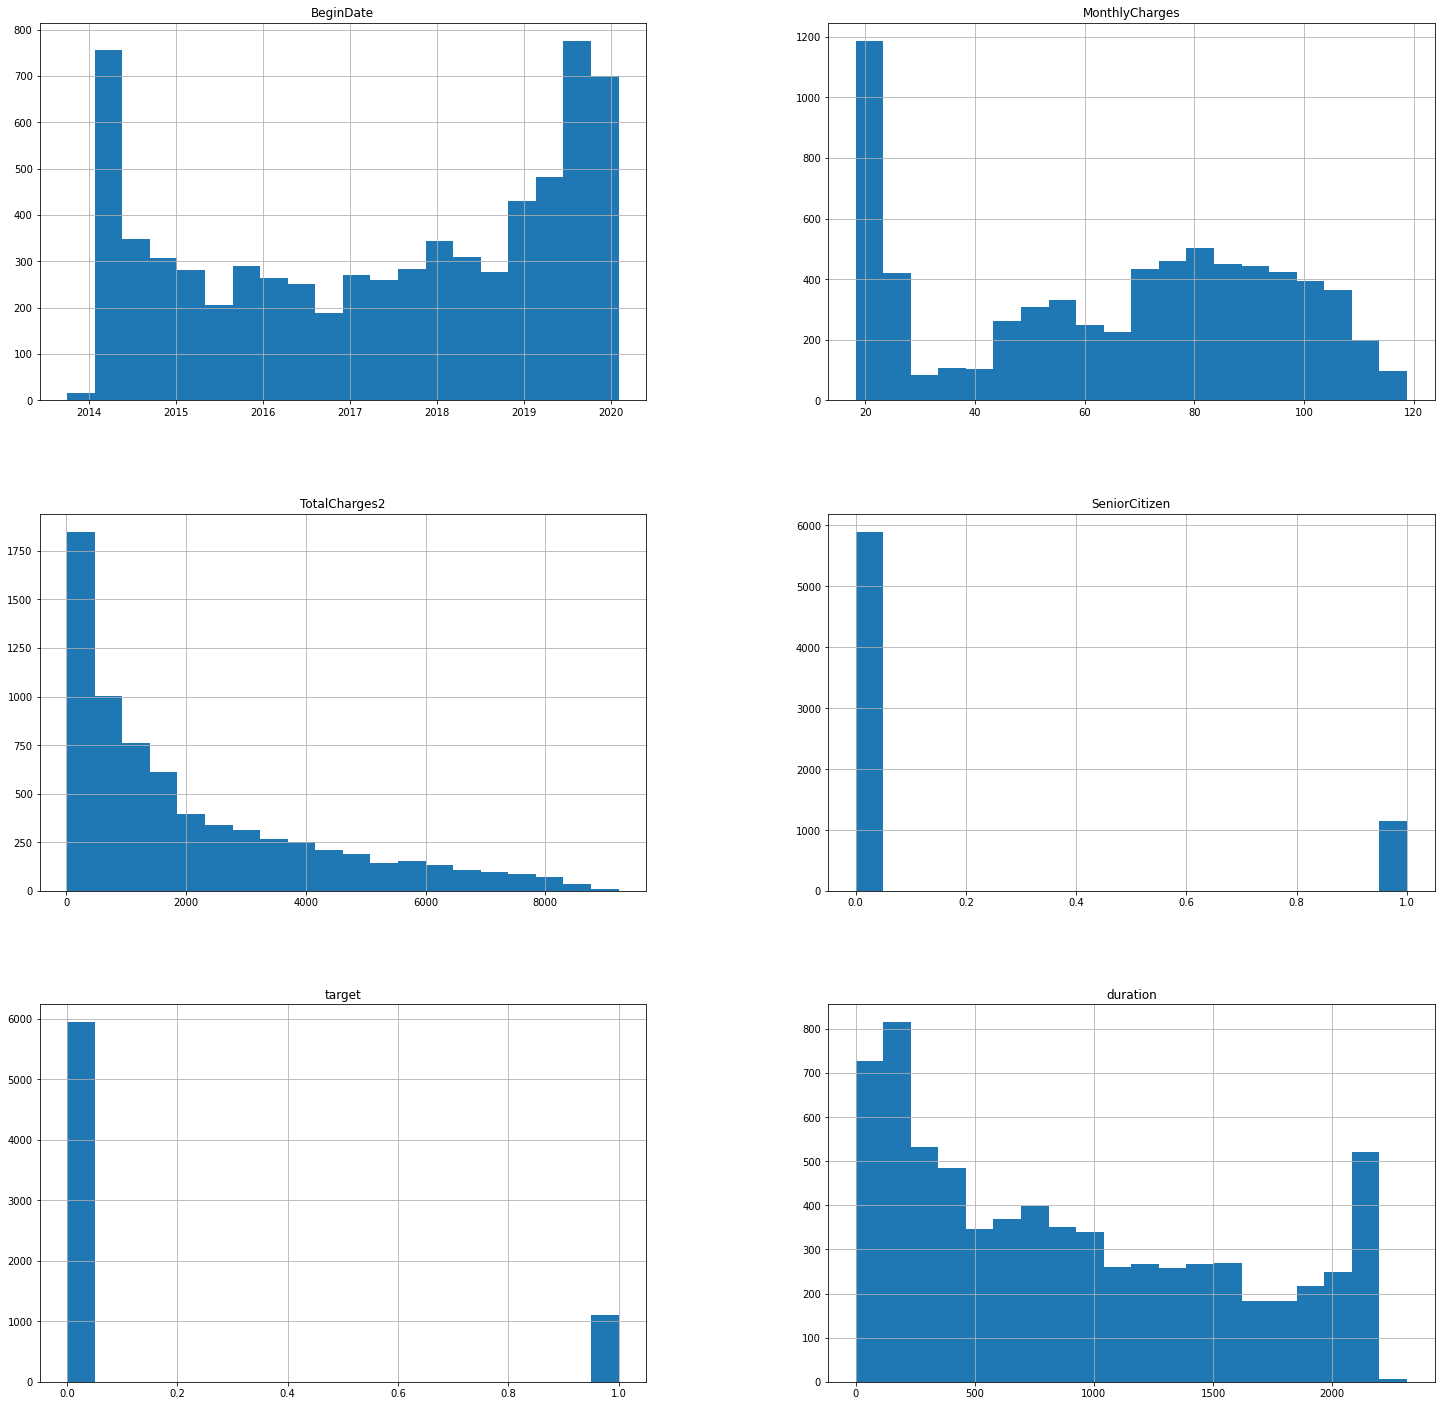

In [34]:
df.hist(bins=20, figsize=(25,25))

Число подключений сильно увеличилось в прошлом году, число отключений стабильно растет на протяжении всего времени. Половина людей платит ежемесячно. Ожидаемые графики для доп. услуг - большинство людей их не подключают. Клиентов-пенсионеров достаточно мало, около 15% выборки. Половина клиентов женаты/замужем, только треть имеет детей/является опекуном. Интересная разбивка по Charges, примерно половина клиентов платит достаточно мало, остальные клиенты зачастую платят в несколько раз больше минимума. 

<AxesSubplot:xlabel='MonthlyCharges', ylabel='Count'>

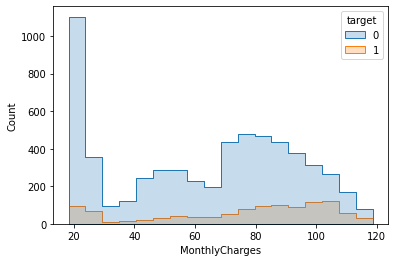

In [35]:
sns.histplot(df, x='MonthlyCharges', hue='target', element="step")

Клиенты, которые платят больше всего ежемесячно уходят чаще. Скорее всего именно это их и не устраивает.

<AxesSubplot:xlabel='duration', ylabel='Count'>

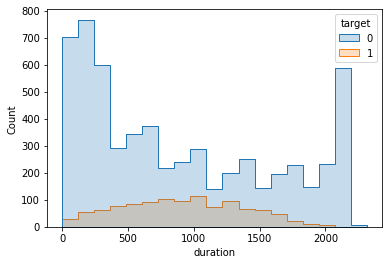

In [36]:
sns.histplot(df, x='duration', hue='target', element="step")

Больше всего уходят клиенты, время с кампанией которых около 1000 дней (3 года). После этого шансы их ухода значительно снижаются. 

<AxesSubplot:xlabel='InternetService', ylabel='Count'>

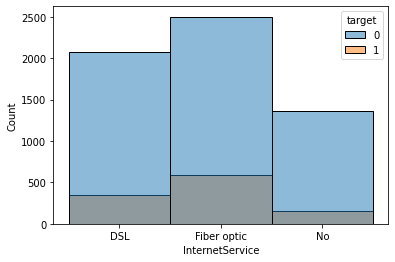

In [37]:
sns.histplot(df, x='InternetService', hue='target', element="bars")

<AxesSubplot:xlabel='MultipleLines', ylabel='Count'>

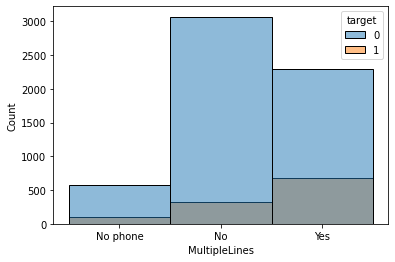

In [38]:
sns.histplot(df, x='MultipleLines', hue='target', element="bars")

Люди с разными типами подключения интернета уходят в примерно одинаковом соотношении. Люди, у которых подключены несколько линий уходят чаще, чем остальные. Возможно, качество этой услуги хуже, чем у конкурентов. 

Посмотрим различные корреляции.

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges2', 'duration']


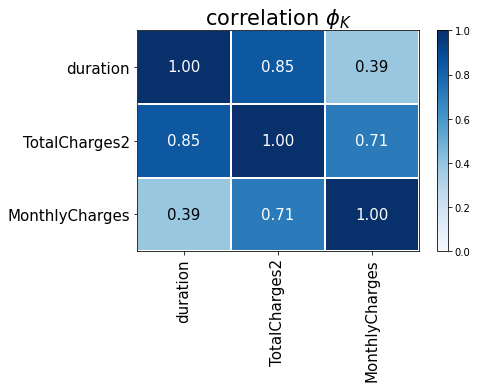

In [39]:
phik_overview = df[['MonthlyCharges','TotalCharges2','duration']].phik_matrix()

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(7,5.5))

Корреляция между месячными и общими затратами достаточно высокая, но не идеальная. Можно предположить, что в большинстве случаев тариф клиента не меняется. Аналогичная корреляция между общими затратами и временем с компанией.

interval columns not set, guessing: ['SeniorCitizen', 'target', 'duration']


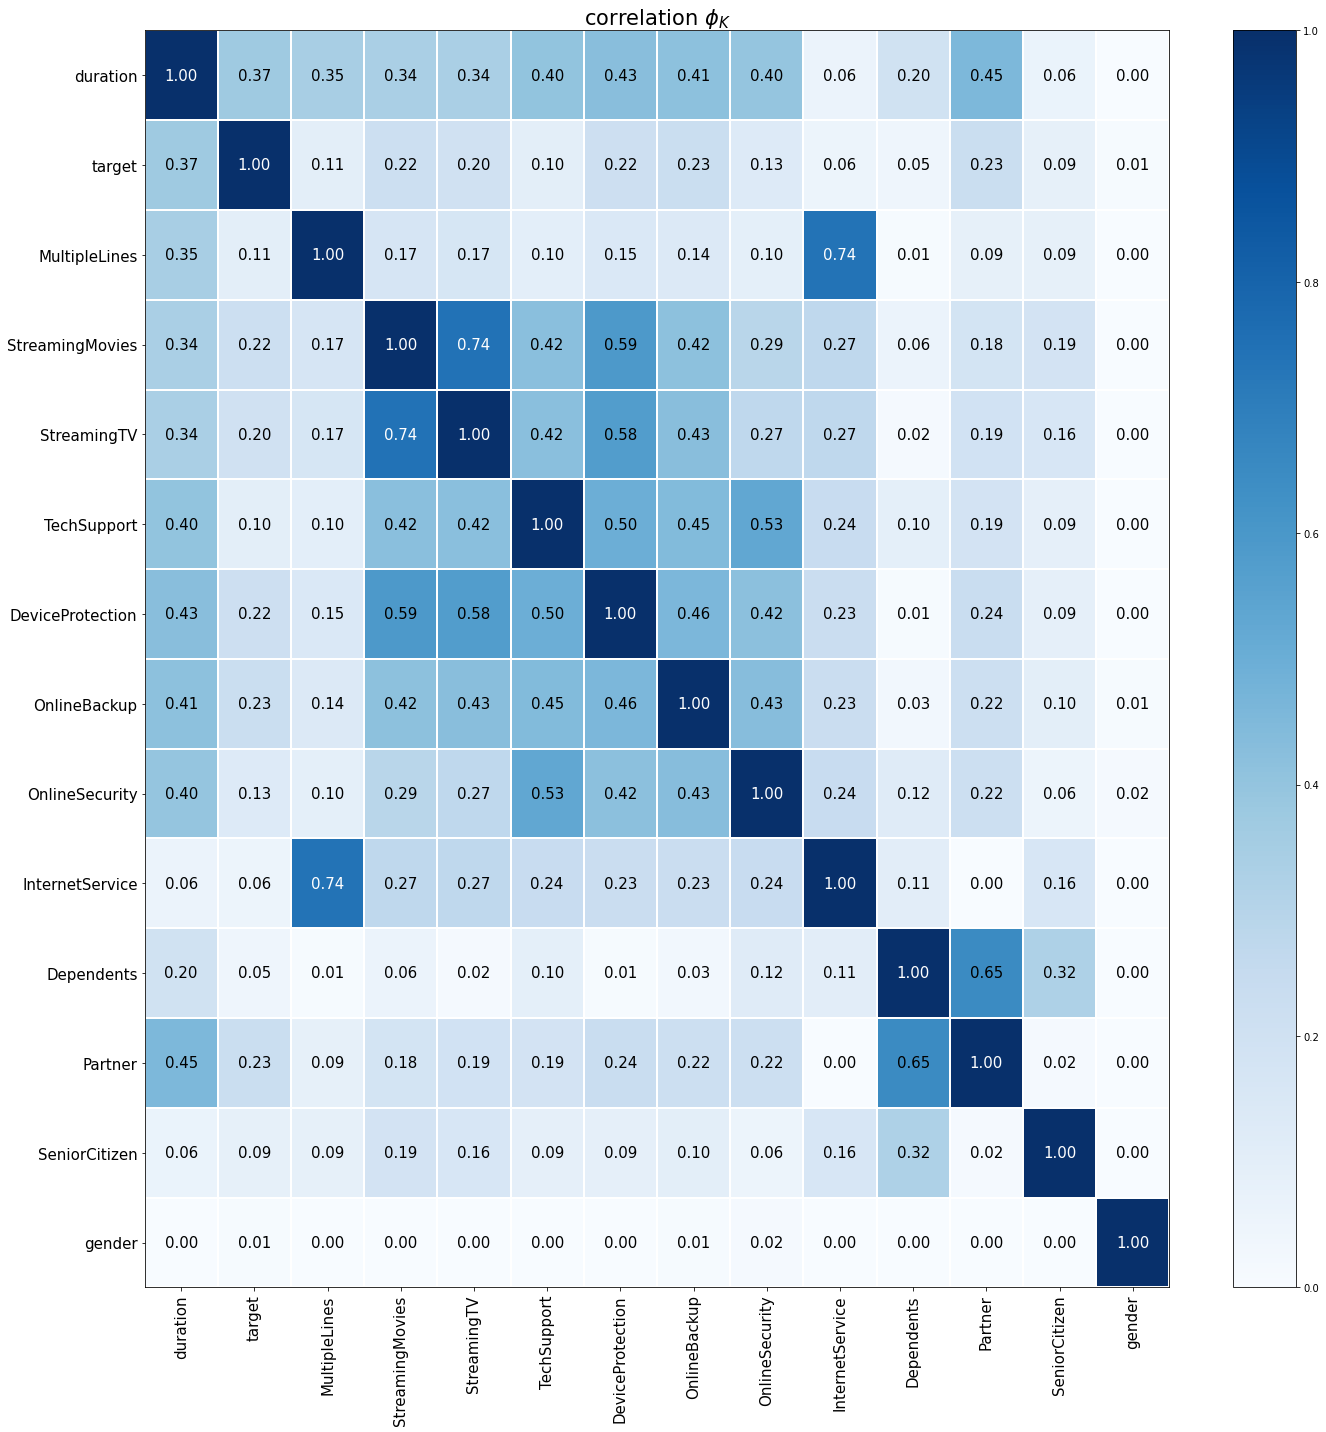

In [40]:
phik_overview = df.iloc[:,-14:].phik_matrix()

plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns, y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map='Blues', title=r'correlation $\phi_K$', fontsize_factor=1.5,
                        figsize=(20,20))

Неожиданная сильная корреляция между типом интернета и несколькими телефонными линиями. Точно будет 100% связь с клиентами, у которых нет интернета, но есть телефон, если не ошибаюсь DSL занимает телефонную линию, так что это тоже логично. Средне-сильная связь между наличием партнера и детей. Сильная корреляция между стриминговыми сервисами, их логично подключать вместе, возможно есть специальный тариф, где оба сервиса. Средняя корреляция между всеми доп. услугами. На это влияет то, что их подключают только клиенты с интернетом, также вероятно, что клиенты часто подключают сразу несколько услуг. Также есть слабо-средняя корреляция между доп. услугами и временем с компанией. Логично, чем больше проходит времени, тем больше шанс пождключения новых услуг.

Теперь можно удалить ненужные признаки. Т.к. есть время с компанией - удалим дату начала и завершения контракта. Также стоит удалить столбцы TotalCharges, корреляция сильная с другим столбцом и маловероятно кто-то из клиентов решает уйти только потому что они заплатили слишком много за услуги в общей сумме, а не в ежемесячном расчете. CustomerID тоже не нужен, это уникальный индикатор. 

In [41]:
df_final = df.drop(columns=['customerID','BeginDate','EndDate','TotalCharges','TotalCharges2'])
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7043 non-null   object 
 1   PaperlessBilling  7043 non-null   object 
 2   PaymentMethod     7043 non-null   object 
 3   MonthlyCharges    7043 non-null   float64
 4   gender            7043 non-null   object 
 5   SeniorCitizen     7043 non-null   int64  
 6   Partner           7043 non-null   object 
 7   Dependents        7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  MultipleLines     7043 non-null   object 
 16  target            7043 non-null   int64  


In [42]:
df_final['SeniorCitizen']=df_final['SeniorCitizen'].astype('float64')
df_final['target']=df_final['target'].astype('float64')
df_final['duration']=df_final['duration'].astype('float64')

## Обучение моделей

In [43]:
features = df_final.drop(['target'], axis=1)
target = df_final['target']
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.25, random_state=state)

In [44]:
columns_to_transform = ['Type','PaperlessBilling', 'PaymentMethod','gender','Partner','Dependents',
                        'InternetService','OnlineSecurity', 'OnlineBackup','DeviceProtection',
                        'TechSupport','StreamingTV','StreamingMovies','MultipleLines']

In [45]:
enc = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
features_train[columns_to_transform] = enc.fit_transform(features_train[columns_to_transform])
features_test[columns_to_transform] = enc.transform(features_test[columns_to_transform])

/tmp/ipykernel_31/1444488255.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[columns_to_transform] = enc.fit_transform(features_train[columns_to_transform])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_31/1444488255.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_inde

In [46]:
model_rfc = RandomForestClassifier(random_state=state)
model_rfc.fit(features_train,target_train)
parameters = {'n_estimators' : [int(x) for x in np.linspace(start = 1, stop = 150, num = 10)], 
              'max_depth' : sp_randInt(1, 10),
              'max_features' : sp_randInt(1, 5), 'min_samples_leaf' : sp_randInt(1, 5)}
randm_src = RandomizedSearchCV(estimator=model_rfc, param_distributions=parameters, cv=3, n_iter=100,
                               random_state=state, scoring = 'roc_auc')
randm_src.fit(features_train, target_train)
print(randm_src.best_params_)
randm_src.best_score_

{'max_depth': 8, 'max_features': 3, 'min_samples_leaf': 2, 'n_estimators': 116}


0.8293536111224711

In [230]:
%%time
parameters2 = {'depth': [5,6,7,8,9,10],
              'learning_rate': [0.01,0.02,0.03,0.04,0.05,0.001,0.1,0.2,0.5,0.005],
              'iterations': [500,600,700,800,900,1000,1500,2000,2500,3000],
             }
model_cbc = CatBoostClassifier(silent=True, random_state=state, eval_metric='AUC')
randm_src = RandomizedSearchCV(estimator=model_cbc, param_distributions=parameters2, cv=3, n_iter=50, random_state=state)
randm_src.fit(features_train, target_train)
print(randm_src.best_params_)
randm_src.best_score_

{'learning_rate': 0.1, 'iterations': 1000, 'depth': 5}
Wall time: 36min 25s


0.9087472897630479

CatBoost показывает лучшие результаты, проверим ее на тестовой выборке.

## Тестирование лучшей модели

In [47]:
model_cbc = CatBoostClassifier(verbose = 1000, random_state=state, eval_metric='AUC',
                              learning_rate = 0.1, iterations = 1000, depth = 5)
model_cbc.fit(features_train, target_train)
predictions = model_cbc.predict_proba(features_test)[:, 1]
predictions2 = model_cbc.predict(features_test)
print('AUC-ROC на тестовой выборке:', roc_auc_score(target_test, predictions))
print('Accuracy на тестовой выборке:', accuracy_score(target_test, predictions2))

0:	total: 149ms	remaining: 2m 29s
999:	total: 3.1s	remaining: 0us
AUC-ROC на тестовой выборке: 0.9281767324747319
Accuracy на тестовой выборке: 0.9307211811470755


Text(0.5, 1.0, 'Feature Importance')

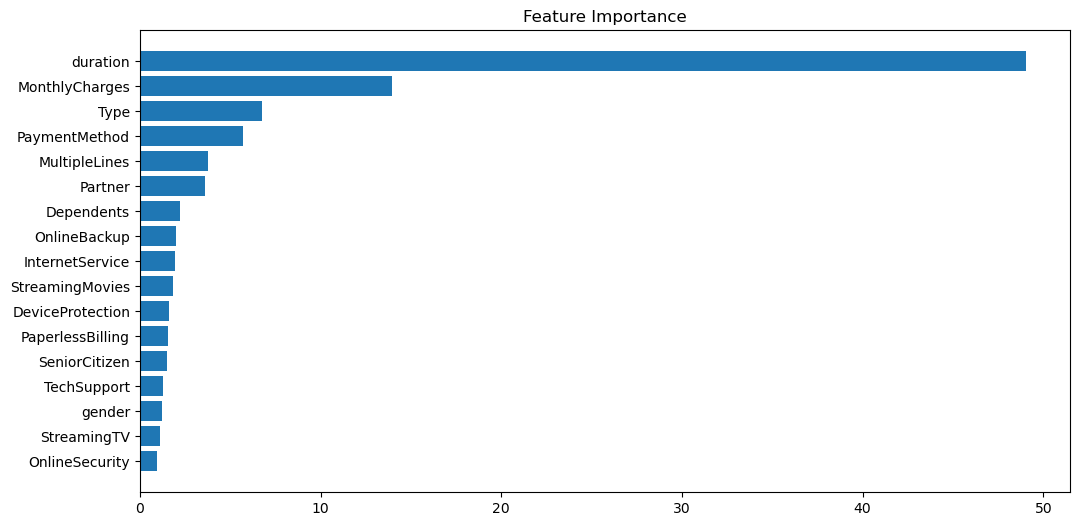

In [48]:
feature_importance = model_cbc.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(features_test.columns)[sorted_idx])
plt.title('Feature Importance')

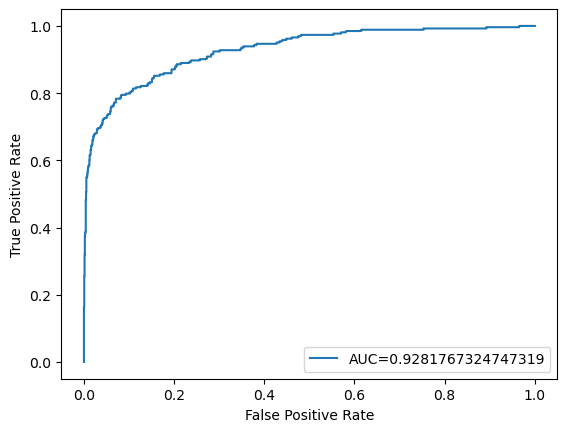

In [49]:
y_pred_proba = model_cbc.predict_proba(features_test)[::,1]
fpr, tpr,_ = roc_curve(target_test,  y_pred_proba)
auc = roc_auc_score(target_test, y_pred_proba)
plt.plot(fpr,tpr,label="AUC="+str(auc))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

Обе метрики больше 0.85, что достаточно для цели проекта. Features importance показывает, что модель в основном ориентируется на 4-5 признаков, отдавая наибольший приоритет duration. На 2 месте MonthlyCharges - логично, стоимость услуг зачастую влияет на поведение клиентов. Type, PaymentMethod и MultipleLines на 3, 4 и 5 месте соответсвенно. До этого была гипотеза, что возможно проблема в качестве услуги нескольких линий, зависимость от частоты платежа тоже понятна - если услуги оплачены на год, то скорее всего клиент не уйдет до их окончания. Также клиенты реже видят чеки оплаты, так что у них меньше шансов задуматься о том, что они платят слишком много. Способ оплаты может косвенно влиять на уход - автоматическое списание не требует никакой концентрации, когда ручная оплата (особенно чек письмом) дает клиенту больше шансов пересмотреть свое отношение к услугам.

## Вывод

В ходе работы были достигнуты поставленные цели - была создана модель с метрикой AUC-ROC равной 0.92, что превышает поставленную планку в 0.85. Также модель обладает точностью 0.93.<br>
Также в ходе работы были установлены корреляции между несколькими признаками (интернет-несколько телефонных линий, стриминг фильмов-стриминг ТВ, наличие партнера-наличие детей, и другие менее сильные связи).<br>
Для улучшения результатов были созданы новые признаки - время с компанией и статус договора (целевой признак).<br>
Найдена корреляция между отключением клиента и признаками MultipleLines, Type и PaymentMethod. Возможно, следует сравнить качество услуг с конкурентами, а также глубже исследовать, как на клиентов влияет частота и тип оплаты услуг. <br>
Во время предобработки была найдена единственная проблема в выгрузке данных - отсутствие данных в столбце TotalCharges, если договор был заключен в день выгрузки. Не влияет на результаты проекта, т.к. данный признак не используется при обучении модели. 

# Отчет о проведенной работе

## Введение

Оператор связи хочет научиться предсказывать отток клиентов, для того чтобы предлагать им промокоды и специальные условия в этом случае. Компания предлагает следующие услуги:
1. Телефонная связь (с возможностью подключения нескольких линий одновременно)
2. Интернет (DSL и Fiber Optic)
3. Доп. услуги:
- DeviceProtection
- OnlineSecurity
- TechSupport
- OnlineBackup
- StreamingTV
- StreamingMovies

Построить модель, способную наиболее точно предсказать собирается ли уходить клиент, используя данные об используемых им услугах, их стоимости, а также его персональных данных. Минимальная точность предсказаний по метрике AUC-ROC >= 0.85.

## Датасет

Данные состоят из файлов, полученных из разных источников:
- contract_new.csv — информация о договоре;
- personal_new.csv — персональные данные клиента;
- internet_new.csv — информация об интернет-услугах;
- phone_new.csv — информация об услугах телефонии.

Информация о договорах актуальна на 1 февраля 2020.<br>
Из данных был собран общий датасет, после чего получены 2 новых признака - status (целевой признак отключения клиента) и duration (кол-во дней клиента с компанией.

Из датасета были убраны договора, заключенные в день выгрузки из-за проблем с расчетом затрат клиента. Заполнены пропуски, полученные в ходе соединения датасетов. После создания новых признаков были убраны следующие признаки:
- BeginDate
- EndDate
- customerID (сделан индексом)
- TotalCharges

Все остальные признаки используются при обучении модели (размер финального датасета - 17x7043).

## Обучение модели

Датасет был разделен на обучающую и тестовую выборку (тест - 0.25 датасета). random_state используемый во всех частях проекта - 280823. Были обучены 2 модели (RandomForestClassifier и CatBoostClassifier) на следующих признаках:

0.   Type
1.   PaperlessBilling
2.   PaymentMethod
3.   MonthlyCharges
4.   gender
5.   SeniorCitizen
6.   Partner
7.   Dependents
8.   InternetService
9.   OnlineSecurity
10.  OnlineBackup
11.  DeviceProtection
12.  TechSupport
13.  StreamingTV
14.  StreamingMovies
15.  MultipleLines
16.  target
17.  duration

По итогам кросс-валидации лучшей моделью оказалась CatBoost со следующими гиперпараметрами:

**CatBoostClassifier(verbose = 1000, random_state=280823, eval_metric='AUC',
                              learning_rate = 0.1, iterations = 1000, depth = 5)**

Во время тестировки модель обладала следующими метрик

## Отличия от исходного плана работ

Добавлено заполнение пропусков, кодирование признаков перенесено из предобратки в обучение модели. В проекте не использовалась модель логистической регрессии (требует другой кодировки данных, маловероятно выдаст лучший результат).

## Трудности в работе, ключевые этапы

Трудностей в работе не возникало.

Ключевым этапом работы является предобработка. Модель в основном ориентируется на созданный признак - duration, так что в нем нельзя допустить утечку данных.

## Результаты

В ходе работы были достигнуты поставленные цели - была создана модель с метрикой AUC-ROC равной 0.92, что превышает поставленную планку в 0.85. Также модель обладает точностью 0.93.<br>
Также в ходе работы были установлены корреляции между несколькими признаками (интернет-несколько телефонных линий, стриминг фильмов-стриминг ТВ, наличие партнера-наличие детей, и другие менее сильные связи).<br>
Найдена корреляция между отключением клиента и признаками MultipleLines, Type и PaymentMethod. Возможно, следует сравнить качество услуг с конкурентами, а также глубже исследовать, как на клиентов влияет частота и тип оплаты услуг. <br>